# Tarea 2: Deep Learning 2025
## Enunciado
Se deberá implementar y sintonizar dos modelos de Deep Learning aplicados a los datasets ya asignados en la Tarea1. El objetivo de la tera es comparar el rendimiento y la eficiencia entre distintas arquitecturas neuronales. El primer modelo será una red neuronal profunda compuesta por capas densas totalmente conectadas, y el segundo una red convolucional 1D (Conv1D) aplicada sobre el eje de características del mismo dataset. Ambos modelos deberán ser entrenados desde cero, evaluando las métricas de desempeño RMSE, MAE y R2, junto con el tiempo total de entrenamiento y tiempo promedio de inferencia por muestra. Se espera que cada alumno realice la búsqueda de la mejor configuración de hiperparámetros (número de capas, ancho, tasa de aprendizaje, tipo de activación, dropout, etc.) y presenten un análisis comparativo de resultados que discuta cuál modelo logra mejor precisión y eficiencia computacional en términos de tiempo de entrenamiento e inferencia.

La tarea se entrega en formato Jupyter Lab en la plataforma Adecca, entregas fuera de  lazo o fuera de la plataforma no serán recibidas y se evaluaran con nota 1.

Fecha de Entrega: 18 de Noviembre, 14:00

- Alumno: Francisco Eduardo Morales Arias
- Profesor: Cristhian Alejandro Aguilera Carrasco

---

## Librerías

In [1]:
try:
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt

    import time
    import warnings

    from sklearn.model_selection import train_test_split, RandomizedSearchCV
    from sklearn.preprocessing import StandardScaler, OneHotEncoder
    from sklearn.impute import SimpleImputer
    from sklearn.metrics import mean_squared_error, mean_absolute_error
    
    from sklearn.ensemble import (
        RandomForestRegressor, 
        GradientBoostingRegressor, 
        BaggingRegressor,
        VotingRegressor, 
        StackingRegressor
    )
    from sklearn.tree import DecisionTreeRegressor
    from sklearn.linear_model import LinearRegression
    
    import tensorflow as tf
    from tensorflow import keras
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
    
    from scipy.stats import randint, uniform
except ImportError as e:
    !pip install -q numpy matplotlib opencv-python tensorflow scikit-learn seaborn
    print('Error, porfavor renicia el kernel y ejecuta esta celda nuevamente')

---

## Importar datos.
Mediante una celda adicional en la tarea anterior, y utilizando joblib, se exportaron archivos de importancia:
- Escalador para X.
- Escalador para Y.
- Datos de test para x.
- Datos de entrenamiento para X.
- Datos de test pero no escalados para y.
- Datos de entrenamiento para y.

El objetivo de esto es agilizar el flujo de trabajo, generar un documento mas limpio y evitar código innecesario.

In [2]:
warnings.filterwarnings('ignore')

df = pd.read_csv('factory_sensors_draw2_clean.csv')

In [3]:
X = df.drop('quality_score', axis=1)
y = df['quality_score']
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [4]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.25, random_state=42
)

In [5]:
print(f"\n--- Tamaños de los sets ---")
print(f"Train: {X_train.shape[0]} muestras")
print(f"Validation: {X_val.shape[0]} muestras")
print(f"Test: {X_test.shape[0]} muestras")


--- Tamaños de los sets ---
Train: 3366 muestras
Validation: 1122 muestras
Test: 1122 muestras


## Imputación de datos

In [6]:
categorical_columns = X_train.select_dtypes(include=['object']).columns.tolist()
encoder = OneHotEncoder(sparse_output=False,handle_unknown='ignore')
one_hot_en_train = encoder.fit_transform(X_train[categorical_columns])
one_hot_en_test = encoder.transform(X_test[categorical_columns])

one_hot_df_train = pd.DataFrame(one_hot_en_train,
                                columns=encoder.get_feature_names_out(categorical_columns), 
                                index=X_train.index)

one_hot_df_test = pd.DataFrame(one_hot_en_test, 
                               columns=encoder.get_feature_names_out(categorical_columns), 
                               index=X_test.index)

one_hot_df_val = pd.DataFrame(one_hot_en_test, 
                               columns=encoder.get_feature_names_out(categorical_columns), 
                               index=X_val.index)

X_train_v2 = pd.concat([X_train, one_hot_df_train], axis=1)
X_test_v2 = pd.concat([X_test, one_hot_df_test], axis=1)
X_val_v2  = pd.concat([X_val, one_hot_df_val], axis=1)

X_train_v2 = X_train_v2.drop(categorical_columns, axis=1)
X_test_v2 = X_test_v2.drop(categorical_columns, axis=1)
X_val_v2 = X_val_v2.drop(categorical_columns, axis=1)

len(X_train_v2.columns),X_train_v2.columns,len(X_test_v2.columns),X_test_v2.columns,len(X_val_v2.columns),X_val_v2.columns

(42,
 Index(['Unnamed: 0', 's1', 's2', 's3', 's4', 's5', 's6', 's7', 's8', 's9',
        's10', 's11', 's12', 's13', 's14', 's15', 's16', 's17', 's18', 's19',
        's20', 'vibration_rms', 'temp_c', 'pressure_bar', 'humidity_pct',
        'operator_id', 'line_id', 'hora', 'mes', 'dia_semana', 'machine_type_A',
        'machine_type_B', 'machine_type_C', 'machine_type_nan', 'shift_day',
        'shift_evening', 'shift_night', 'shift_nan', 'plant_region_Centro',
        'plant_region_Norte', 'plant_region_Sur', 'plant_region_nan'],
       dtype='object'),
 42,
 Index(['Unnamed: 0', 's1', 's2', 's3', 's4', 's5', 's6', 's7', 's8', 's9',
        's10', 's11', 's12', 's13', 's14', 's15', 's16', 's17', 's18', 's19',
        's20', 'vibration_rms', 'temp_c', 'pressure_bar', 'humidity_pct',
        'operator_id', 'line_id', 'hora', 'mes', 'dia_semana', 'machine_type_A',
        'machine_type_B', 'machine_type_C', 'machine_type_nan', 'shift_day',
        'shift_evening', 'shift_night', 'shift_

In [7]:
try:
    X_train_v2.pop('machine_type_nan')
    X_train_v2.pop('shift_nan')
    X_train_v2.pop('plant_region_nan')
    X_test_v2.pop('machine_type_nan')
    X_test_v2.pop('shift_nan')
    X_test_v2.pop('plant_region_nan')
    X_val_v2.pop('machine_type_nan')
    X_val_v2.pop('shift_nan')
    X_val_v2.pop('plant_region_nan')
except:
    pass
len(X_train_v2.columns),X_train_v2.columns,len(X_test_v2.columns),X_test_v2.columns,len(X_val_v2.columns),X_val_v2.columns

(39,
 Index(['Unnamed: 0', 's1', 's2', 's3', 's4', 's5', 's6', 's7', 's8', 's9',
        's10', 's11', 's12', 's13', 's14', 's15', 's16', 's17', 's18', 's19',
        's20', 'vibration_rms', 'temp_c', 'pressure_bar', 'humidity_pct',
        'operator_id', 'line_id', 'hora', 'mes', 'dia_semana', 'machine_type_A',
        'machine_type_B', 'machine_type_C', 'shift_day', 'shift_evening',
        'shift_night', 'plant_region_Centro', 'plant_region_Norte',
        'plant_region_Sur'],
       dtype='object'),
 39,
 Index(['Unnamed: 0', 's1', 's2', 's3', 's4', 's5', 's6', 's7', 's8', 's9',
        's10', 's11', 's12', 's13', 's14', 's15', 's16', 's17', 's18', 's19',
        's20', 'vibration_rms', 'temp_c', 'pressure_bar', 'humidity_pct',
        'operator_id', 'line_id', 'hora', 'mes', 'dia_semana', 'machine_type_A',
        'machine_type_B', 'machine_type_C', 'shift_day', 'shift_evening',
        'shift_night', 'plant_region_Centro', 'plant_region_Norte',
        'plant_region_Sur'],
      

In [8]:
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')

array_train_imputado = imputer.fit_transform(X_train_v2)
array_test_imputado = imputer.transform(X_test_v2)


X_train_v3 = pd.DataFrame(array_train_imputado, 
                       columns=X_train_v2.columns, 
                       index=X_train_v2.index)

X_test_v3 = pd.DataFrame(array_test_imputado, 
                      columns=X_test_v2.columns, 
                      index=X_test_v2.index)

X_val_v3 = pd.DataFrame(array_test_imputado, 
                      columns=X_val_v2.columns, 
                      index=X_val_v2.index)

X_train_v3.isnull().sum(),X_test_v3.isnull().sum(),X_val_v3.isnull().sum()

(Unnamed: 0             0
 s1                     0
 s2                     0
 s3                     0
 s4                     0
 s5                     0
 s6                     0
 s7                     0
 s8                     0
 s9                     0
 s10                    0
 s11                    0
 s12                    0
 s13                    0
 s14                    0
 s15                    0
 s16                    0
 s17                    0
 s18                    0
 s19                    0
 s20                    0
 vibration_rms          0
 temp_c                 0
 pressure_bar           0
 humidity_pct           0
 operator_id            0
 line_id                0
 hora                   0
 mes                    0
 dia_semana             0
 machine_type_A         0
 machine_type_B         0
 machine_type_C         0
 shift_day              0
 shift_evening          0
 shift_night            0
 plant_region_Centro    0
 plant_region_Norte     0
 plant_regio

In [9]:
def how_many_outliers(df):
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1

    outliers = ((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR)))
    try:
        outliers= outliers.sum(axis=1).sort_values()
    except:
        outliers= outliers.sum().sort_values()
    outliers = outliers[outliers!=0]
    return outliers
    
outliers = how_many_outliers(X_train_v3)
outliers.sort_values(ascending=False)

890     22
4349    22
380     22
5405    22
3438    22
        ..
1234     1
5346     1
2011     1
5456     1
1066     1
Length: 2402, dtype: int64

In [10]:
numerical_cols = ['s1', 's2', 's3', 's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11',
       's12', 's13', 's14', 's15', 's16', 's17', 's18', 's19', 's20',
       'vibration_rms', 'temp_c', 'pressure_bar', 'humidity_pct',
       'operator_id', 'line_id', 'hora', 'mes', 'dia_semana']

for col in numerical_cols:

    Q1 = X_train_v3[col].quantile(0.25)
    Q3 = X_train_v3[col].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_fence = Q1 - (1.5 * IQR)
    upper_fence = Q3 + (1.5 * IQR)
    
    X_train_v3[col] = X_train_v3[col].clip(lower_fence, upper_fence)

    X_test_v3[col] = X_test_v3[col].clip(lower_fence, upper_fence)

    X_val_v3[col] = X_val_v3[col].clip(lower_fence, upper_fence)

    
how_many_outliers(X_train_v3).sort_values(ascending=False),how_many_outliers(X_test_v3).sort_values(ascending=False),how_many_outliers(X_val_v3).sort_values(ascending=False)

(5169    3
 4077    3
 2558    3
 5607    3
 3851    3
        ..
 3241    1
 3740    1
 3294    1
 1293    1
 3526    1
 Length: 1973, dtype: int64,
 4019    13
 4540    12
 3765    12
 3203    11
 3355    11
         ..
 1578     1
 1740     1
 731      1
 1632     1
 1020     1
 Length: 751, dtype: int64,
 1387    13
 4533    12
 5315    12
 4635    11
 3695    11
         ..
 1250     1
 3957     1
 3005     1
 4039     1
 134      1
 Length: 751, dtype: int64)

In [11]:
scaler = StandardScaler()

X_train_v3[numerical_cols] = scaler.fit_transform(X_train_v3[numerical_cols])
X_test_v3[numerical_cols] = scaler.transform(X_test_v3[numerical_cols])
X_val_v3[numerical_cols] = scaler.transform(X_test_v3[numerical_cols])


X_train_clean = X_train_v3
X_test_clean = X_test_v3
X_val_clean = X_val_v3

In [12]:
Q1_y = y_train.quantile(0.25)
Q3_y = y_train.quantile(0.75)

IQR_y = Q3_y - Q1_y

lower_fence_y = Q1_y - (1.5 * IQR_y)
upper_fence_y = Q3_y + (1.5 * IQR_y)

print(f"límites para la columna y: inferior={lower_fence_y:.2f}, superior={upper_fence_y:.2f}")

y_train_v2 = y_train.clip(lower_fence_y, upper_fence_y)
y_test_v2 = y_test.clip(lower_fence_y, upper_fence_y)
y_val_v2 = y_val.clip(lower_fence_y, upper_fence_y)

print(y_train_v2.describe())
print(y_test_v2.describe())
print(y_val_v2.describe())

límites para la columna y: inferior=13.68, superior=136.34
count    3366.000000
mean       76.482425
std        26.210958
min        13.683000
25%        59.680318
50%        72.897039
75%        90.345196
max       136.342513
Name: quality_score, dtype: float64
count    1122.000000
mean       76.499289
std        27.193655
min        13.683000
25%        58.981657
50%        73.003027
75%        92.252757
max       136.342513
Name: quality_score, dtype: float64
count    1122.000000
mean       76.310745
std        26.383128
min        13.683000
25%        59.804847
50%        72.612288
75%        89.618603
max       136.342513
Name: quality_score, dtype: float64


In [13]:
scaler_y = StandardScaler()

y_train_v3 = scaler_y.fit_transform(y_train_v2.values.reshape(-1,1))
y_test_v3 = scaler_y.transform(y_test_v2.values.reshape(-1,1))
y_val_v3 = scaler_y.transform(y_val_v2.values.reshape(-1,1))

y_train_clean = y_train_v3
y_test_clean = y_test_v3
y_val_clean = y_val_v3

print(y_train_clean.shape)
print(y_test_clean.shape)
print(y_train_clean[:5])

(3366, 1)
(1122, 1)
[[ 0.28188092]
 [-0.26380491]
 [ 2.28412033]
 [-0.54345825]
 [ 0.05895534]]


---

## Primer Modelo: Red neuronal profunda.

In [14]:
INPUT_SHAPE = (X_train_clean.shape[1],) # (38,)

def build_dnn_model():
    model = Sequential([
        # Capa de entrada
        Dense(128, activation='relu', input_shape=INPUT_SHAPE),
        BatchNormalization(),
        Dropout(0.3),

        # Capa oculta 2
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        
        # Capa oculta 3
        Dense(32, activation='relu'),

        # Capa de salida (1 neurona para regresión)
        Dense(1) 
    ])

    # Compilar el modelo
    model.compile(optimizer='adam', 
                  loss='mean_squared_error',
                  metrics=['mae', 'mse']) # MAE y MSE son útiles de monitorear
    
    return model

# Crear nuestro modelo base
model_dnn_base = build_dnn_model()
model_dnn_base.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 128)                 │           5,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,257 (63.50 KB)

 Trainable params: 15,873 (62.00 KB)

 Non-trainable params: 384 (1.50 KB)

Epoch 1/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 1.5095 - mae: 0.9481 - mse: 1.5095 - val_loss: 1.0788 - val_mae: 0.8200 - val_mse: 1.0788
Epoch 2/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.2177 - mae: 0.8491 - mse: 1.2177 - val_loss: 1.0267 - val_mae: 0.7789 - val_mse: 1.0267
Epoch 3/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1090 - mae: 0.8112 - mse: 1.1090 - val_loss: 1.0523 - val_mae: 0.7715 - val_mse: 1.0523
Epoch 4/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0915 - mae: 0.8098 - mse: 1.0915 - val_loss: 1.0360 - val_mae: 0.7731 - val_mse: 1.0360
Epoch 5/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0366 - mae: 0.7883 - mse: 1.0366 - val_loss: 1.0226 - val_mae: 0.7852 - val_mse: 1.0226
Epoch 6/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0418 - mae: 0.7904 - mse: 1.0418 - val_loss: 1.0275 - val_mae: 0.7719 - val_mse: 1.0275
Epoch 7/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0487 - mae: 0.7966 - mse: 1.048

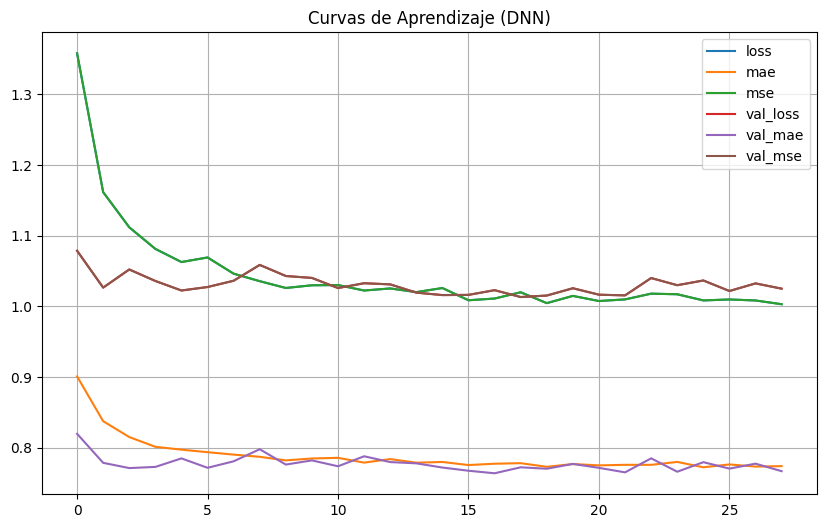

In [15]:
# Callback para detener el entrenamiento si la pérdida de validación no mejora
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,       # Esperar 10 épocas antes de parar
    restore_best_weights=True # Restaurar los pesos del mejor modelo
)

# Medir el tiempo de entrenamiento
start_time = time.time()

history = model_dnn_base.fit(
    X_train_clean, y_train_clean,
    epochs=100,       # Un número alto, EarlyStopping decidirá cuándo parar
    batch_size=32,
    validation_data=(X_val_clean, y_val_clean),
    callbacks=[early_stopping],
    verbose=1
)

end_time = time.time()
training_time_dnn = end_time - start_time

print(f"\n--- Entrenamiento DNN Finalizado ---")
print(f"Tiempo total de entrenamiento: {training_time_dnn:.2f} segundos")

# Plotear la historia para ver el aprendizaje
pd.DataFrame(history.history).plot(figsize=(10, 6))
plt.grid(True)
plt.title('Curvas de Aprendizaje (DNN)')
plt.show()

---
## Segundo Modelo: Red convolucional 1D

---
## Análisis comparativo